<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/Final_CX_CB_Run_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you want something closer to a minimal base run, you'd want:

This is the most basic statistical models (mean, median, mode, seasonal naive)
- No hyperparameter optimization
- Minimal feature engineering
- Simple train/test splits
-Default model parameters

**Business Explanation: Call Center Forecasting Base Run Test**

## What We're Doing

We're testing the most basic ways to predict how many calls your call center will receive each day. Think of this as establishing a "starting line" before we try more complex approaches.

## The Four Simple Methods We're Testing

**1. Average Method:** "Tomorrow will be like our typical day"
- Uses the overall average of all past days
- Simple but ignores seasonal patterns

**2. Median Method:** "Tomorrow will be like our middle-performing day"
- Uses the middle value, less affected by unusually busy or slow days
- More stable than average when you have extreme outliers

**3. Most Common Method:** "Tomorrow will be like our most frequent type of day"
- Finds the call volume that happens most often
- Good when your operation has very consistent patterns

**4. Same Day Last Week:** "Tomorrow will be like the same day last week"
- Uses last Monday to predict this Monday, last Tuesday for this Tuesday, etc.
- Captures day-of-week patterns (like "Mondays are always busier")

## Why Start Here?

Before investing in complex algorithms, we need to know: "How well can simple common-sense approaches work?" If a basic method works well enough, you might not need expensive complex solutions.

## What the Results Tell You

**If "Same Day Last Week" wins:** Your call patterns are strongly driven by day-of-week effects. Focus on scheduling models that account for weekly cycles.

**If "Average" or "Median" wins:** Your call volume is relatively stable with minimal patterns. Simple capacity planning may be sufficient.

**If no method beats "Same Day Last Week":** You have strong weekly patterns that any forecasting solution must account for.

## Business Value

- **Cost:** These simple methods cost almost nothing to implement
- **Speed:** Results available immediately
- **Baseline:** Establishes minimum acceptable performance
- **Decision Framework:** Helps determine if you need more sophisticated (expensive) forecasting tools

This test answers: "What's the simplest approach that could work?" before you invest in complex solutions.

In [ ]:
!nvidia-smi

Sun Sep 21 22:16:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

# Example: Move a tensor to the GPU
x = torch.randn(10, 10).to(device)

# Example: Move a model to the GPU
# model = YourModel().to(device)

Using GPU: Tesla T4


In [2]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install tensorflow
!pip install tbats
!pip install pmdarima

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 104.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 69.0 MB/s eta 0:00:00


In [1]:
# BASE RUN CONFIGURATION - SET THESE FIRST
print("CONFIGURATION: BASE RUN MODE")
print("=" * 50)

# Base Run Flags
BASE_RUN_MODE = True
ENABLE_ONLY_BASIC_MODELS = True
ENABLE_ML_MODELS = False
ENABLE_NEURAL = False
ENABLE_ADVANCED_TS = False
ENABLE_OPTIMIZATION = False
USE_SIMPLE_CV = True  # Use only 1 split instead of 3

# Model Version Update for Base Run
if BASE_RUN_MODE:
    MODEL_VERSION = "BASE_RUN_V1"
    print("Model Version: BASE_RUN_V1")
    print("Models: Mean, Median, Mode, Seasonal Naive ONLY")
    print("Cross-Validation: 1 split only")
    print("Feature Engineering: Minimal")
    print("Optimization: DISABLED")
else:
    MODEL_VERSION = "V1_EXPANDED_FINAL"
    print("Model Version: V1_EXPANDED_FINAL")
    print("Models: All models with optimization")

print("=" * 50)
print("Configuration complete. Ready for base run evaluation.")

CONFIGURATION: BASE RUN MODE
Model Version: BASE_RUN_V1
Models: Mean, Median, Mode, Seasonal Naive ONLY
Cross-Validation: 1 split only
Feature Engineering: Minimal
Optimization: DISABLED
Configuration complete. Ready for base run evaluation.


In [2]:
# Core libraries for base run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import time
import psutil

# Statistical libraries
from scipy.stats import mode, trim_mean, gmean

# ML metrics only (no complex models)
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

# Environment check
print("ENVIRONMENT CHECK - BASE RUN")
print("-" * 40)

# RAM Check
ram_gb = psutil.virtual_memory().total / 1e9
print(f'RAM Available: {ram_gb:.1f} GB')

# Visualization setup
plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")
print("Base run environment ready")
print("-" * 40)

ENVIRONMENT CHECK - BASE RUN
----------------------------------------
RAM Available: 54.8 GB
Libraries imported successfully
Base run environment ready
----------------------------------------


In [3]:
def load_call_center_data_base_run(file_path='enhanced_eda_data.csv'):
    """
    Load call center data - BASE RUN VERSION
    Minimal preprocessing, no complex feature engineering
    """
    print("LOADING CALL CENTER DATA - BASE RUN")
    print("=" * 45)

    try:
        # Load main data file
        df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
        print(f"Loaded {len(df)} records from {file_path}")

        # Auto-detect call volume column
        volume_cols = ['calls', 'Calls', 'call_volume', 'Call_Volume', 'volume', 'Volume']
        volume_col = None

        for col in volume_cols:
            if col in df.columns:
                volume_col = col
                break

        if volume_col is None:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            volume_col = numeric_cols[0] if len(numeric_cols) > 0 else df.columns[0]

        print(f"Call volume column identified: {volume_col}")

        # Standardize column name and keep only call volume
        if volume_col != 'calls':
            df = df.rename(columns={volume_col: 'calls'})

        # BASE RUN: Keep only the call volume column
        df = df[['calls']].copy()

        # Basic data cleaning: Remove first and last rows if needed
        print("Basic data cleaning...")
        original_len = len(df)
        if len(df) > 2:
            df = df.iloc[1:-1]
            print(f"   Cleaned: {original_len} → {len(df)} rows")

        # Remove any missing values
        df = df.dropna()

        print(f"\nBASE RUN DATASET OVERVIEW")
        print("-" * 30)
        print(f"   Date range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
        print(f"   Total days: {len(df)}")
        print(f"   Call volume range: {df['calls'].min():.0f} to {df['calls'].max():.0f}")
        print(f"   Average daily calls: {df['calls'].mean():.0f}")
        print("-" * 30)
        print("Base run data loading complete!")

        return df

    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [4]:
def create_time_series_splits_base_run(df, n_splits=1, test_size=7, gap=0):
    """
    Create time series cross-validation splits - BASE RUN VERSION
    Uses only 1 split for speed and simplicity
    """
    print("TIME SERIES CROSS-VALIDATION - BASE RUN")
    print("=" * 45)

    splits = []
    total_size = len(df)

    # Base run uses only 1 split for simplicity
    actual_splits = min(n_splits, 1) if BASE_RUN_MODE else n_splits

    for i in range(actual_splits):
        test_end = total_size - i * test_size
        test_start = test_end - test_size
        train_end = test_start - gap

        if train_end < 30:  # Minimum training size
            print(f"   Warning: Insufficient training data for split {i+1}")
            break

        train_idx = df.index[:train_end]
        test_idx = df.index[test_start:test_end]

        splits.append({
            'train_idx': train_idx,
            'test_idx': test_idx,
            'train_size': len(train_idx),
            'test_size': len(test_idx),
            'split_date': test_idx[0] if len(test_idx) > 0 else None
        })

        print(f"Split {i+1}:")
        print(f"   Training: {len(train_idx)} days ({train_idx[0].strftime('%Y-%m-%d')} to {train_idx[-1].strftime('%Y-%m-%d')})")
        print(f"   Testing:  {len(test_idx)} days ({test_idx[0].strftime('%Y-%m-%d')} to {test_idx[-1].strftime('%Y-%m-%d')})")

    print(f"\nBase run cross-validation setup complete: {len(splits)} split(s)")
    print("-" * 45)
    return splits

In [5]:
class BasicStatisticalModels_BaseRun:
    """
    Basic Statistical Models - BASE RUN VERSION
    Only the 4 core benchmark models: Mean, Median, Mode, Seasonal Naive
    """

    def __init__(self):
        self.models = {}
        self.model_version = MODEL_VERSION

    def fit_all_basic_models(self, y_train):
        """Fit the 4 core basic statistical models"""

        print("   Fitting basic statistical models...")

        # 1. Mean - Simple average of all historical values
        self.models['mean'] = y_train.mean()
        print(f"     Mean: {self.models['mean']:.1f}")

        # 2. Median - Middle value of historical data
        self.models['median'] = y_train.median()
        print(f"     Median: {self.models['median']:.1f}")

        # 3. Mode - Most frequent value (discrete approximation)
        try:
            # Use histogram approach for continuous data
            hist, bin_edges = np.histogram(y_train, bins=50)
            mode_bin = np.argmax(hist)
            mode_value = (bin_edges[mode_bin] + bin_edges[mode_bin + 1]) / 2
            self.models['mode'] = mode_value
            print(f"     Mode: {self.models['mode']:.1f}")
        except:
            # Fallback to median if mode calculation fails
            self.models['mode'] = y_train.median()
            print(f"     Mode: {self.models['mode']:.1f} (fallback to median)")

        # 4. Seasonal Naive - Use same day of week from previous week
        season_length = 7  # Weekly seasonality
        if len(y_train) >= season_length:
            self.models['seasonal_naive'] = {
                'values': y_train.iloc[-season_length:],
                'season_length': season_length
            }
            print(f"     Seasonal Naive: Using last {season_length} days pattern")
        else:
            # If insufficient data, use all available data
            self.models['seasonal_naive'] = {
                'values': y_train,
                'season_length': len(y_train)
            }
            print(f"     Seasonal Naive: Using all {len(y_train)} available days")

        print(f"   Basic models fitted successfully")
        return self

    def predict(self, steps, model_type):
        """Generate forecasts for specified number of steps"""

        if model_type in ['mean', 'median', 'mode']:
            # Return constant forecast for mean, median, mode
            return np.full(steps, self.models[model_type])

        elif model_type == 'seasonal_naive':
            # Return seasonal pattern repeated for forecast horizon
            model_info = self.models['seasonal_naive']
            season_values = model_info['values'].values
            season_length = model_info['season_length']

            forecasts = []
            for i in range(steps):
                # Use seasonal pattern: day i corresponds to season_values[i % season_length]
                season_index = i % season_length
                forecasts.append(season_values[-(season_length - season_index)])

            return np.array(forecasts)

        else:
            # Fallback for unknown model type
            return np.full(steps, self.models.get('mean', 0))

In [6]:
def fit_basic_models_base_run(y_train, forecast_steps):
    """
    Fit ONLY the 4 core basic statistical models - BASE RUN VERSION
    Models: Mean, Median, Mode, Seasonal Naive
    """

    print("FITTING BASIC STATISTICAL MODELS - BASE RUN")
    print("-" * 50)

    results = {}

    # Initialize basic models
    basic_models = BasicStatisticalModels_BaseRun()
    basic_models.fit_all_basic_models(y_train)

    # The 4 core benchmark models for base run
    core_models = ['mean', 'median', 'mode', 'seasonal_naive']

    print(f"   Generating forecasts for {forecast_steps} steps...")

    for model_name in core_models:
        try:
            # Generate prediction
            pred = basic_models.predict(forecast_steps, model_name)

            # Store results with model version
            results[f"{model_name}_{MODEL_VERSION}"] = pred

            print(f"     {model_name.upper()}: ✓ Generated {len(pred)} forecasts")

        except Exception as e:
            print(f"     {model_name.upper()}: ✗ Failed - {str(e)}")
            # Fallback to mean if model fails
            results[f"{model_name}_{MODEL_VERSION}"] = np.full(forecast_steps, y_train.mean())

    print(f"\nBasic models fitting complete: {len(results)} models")
    print(f"Models fitted: {', '.join([name.split('_')[0].title() for name in results.keys()])}")
    print("-" * 50)

    return results

In [7]:
def evaluate_model_standardized_base_run(y_true, y_pred, y_train, model_name):
    """
    Standardized model evaluation with all metrics - BASE RUN VERSION
    Same evaluation framework as complex models for fair comparison
    """

    # Handle NaNs and infinite values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred) | np.isinf(y_true) | np.isinf(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    if len(y_true_clean) == 0:
        print(f"   Warning: {model_name} - No valid predictions after cleaning")
        return {
            'Model': model_name,
            'MAE': np.nan,
            'RMSE': np.nan,
            'MAPE': np.nan,
            'R2': np.nan,
            'MASE': np.nan
        }

    try:
        # 1. Mean Absolute Error
        mae = mean_absolute_error(y_true_clean, y_pred_clean)

        # 2. Root Mean Square Error
        rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))

        # 3. Mean Absolute Percentage Error
        mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean) * 100

        # 4. R-squared Score (coefficient of determination)
        ss_res = np.sum((y_true_clean - y_pred_clean) ** 2)
        ss_tot = np.sum((y_true_clean - np.mean(y_true_clean)) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

        # 5. Mean Absolute Scaled Error (MASE) - using seasonal naive as benchmark
        seasonal_period = 7  # Weekly seasonality
        if len(y_train) > seasonal_period:
            # Calculate seasonal naive errors (benchmark)
            seasonal_naive_errors = np.abs(y_train.iloc[seasonal_period:].values - y_train.iloc[:-seasonal_period].values)
            seasonal_naive_mae = np.mean(seasonal_naive_errors)
        else:
            # Fallback to naive forecast if insufficient seasonal data
            naive_errors = np.abs(y_train.iloc[1:].values - y_train.iloc[:-1].values)
            seasonal_naive_mae = np.mean(naive_errors)

        mase = mae / seasonal_naive_mae if seasonal_naive_mae != 0 else np.inf

        return {
            'Model': model_name,
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'MAPE': round(mape, 2),
            'R2': round(r2, 4),
            'MASE': round(mase, 4)
        }

    except Exception as e:
        print(f"   Warning: {model_name} evaluation failed: {e}")
        return {
            'Model': model_name,
            'MAE': np.nan,
            'RMSE': np.nan,
            'MAPE': np.nan,
            'R2': np.nan,
            'MASE': np.nan
        }

In [8]:
def run_base_run_evaluation():
    """
    Run complete BASE RUN evaluation - Only basic benchmarks
    Focus on Mean, Median, Mode, Seasonal Naive with full reporting
    """
    print("=" * 80)
    print("BASE RUN: BASIC BENCHMARK EVALUATION")
    print("=" * 80)
    print("Purpose: Establish fundamental baseline performance")
    print("Models: Mean, Median, Mode, Seasonal Naive")
    print("Cross-Validation: Single split for computational efficiency")
    print("Optimization: DISABLED (using default parameters only)")
    print("=" * 80)

    all_results = []
    evaluation_start_time = time.time()

    # Use only 1 split for base run (computational efficiency)
    splits_to_use = 1

    for split_idx, split in enumerate(cv_splits[:splits_to_use]):
        print(f"\nEVALUATING SPLIT {split_idx + 1}/{splits_to_use}")
        print("-" * 60)

        # Get data for this split
        train_data = df_raw.loc[split['train_idx']]
        test_data = df_raw.loc[split['test_idx']]

        print(f"Training Period: {train_data.index[0].strftime('%Y-%m-%d')} to {train_data.index[-1].strftime('%Y-%m-%d')}")
        print(f"Testing Period:  {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}")
        print(f"Training Days: {len(train_data)} | Testing Days: {len(test_data)}")

        # Extract target variables
        y_train = train_data['calls']
        y_test = test_data['calls'].values
        forecast_steps = len(test_data)

        # Display basic statistics
        print(f"\nTraining Data Statistics:")
        print(f"   Mean: {y_train.mean():.1f} calls/day")
        print(f"   Median: {y_train.median():.1f} calls/day")
        print(f"   Std Dev: {y_train.std():.1f} calls/day")
        print(f"   Range: {y_train.min():.0f} - {y_train.max():.0f} calls/day")

        # Fit ONLY basic statistical models
        print(f"\nFitting Basic Models for {forecast_steps}-step forecast...")
        basic_results = fit_basic_models_base_run(y_train, forecast_steps)

        # Evaluate each model
        print(f"\nEvaluating Model Performance:")
        print("-" * 40)

        for model_name, predictions in basic_results.items():
            if len(predictions) == len(y_test):
                # Calculate metrics
                metrics = evaluate_model_standardized_base_run(y_test, predictions, y_train, model_name)

                # Add split information
                metrics['split'] = split_idx + 1
                metrics['category'] = 'Basic Benchmark'

                # Store results
                all_results.append(metrics)

                # Display individual results
                clean_name = model_name.replace(f'_{MODEL_VERSION}', '').replace('_', ' ').title()
                print(f"   {clean_name:<20} MAE: {metrics['MAE']:<8.1f} MASE: {metrics['MASE']:<8.3f}")
            else:
                print(f"   {model_name}: ✗ Length mismatch ({len(predictions)} vs {len(y_test)})")

        print(f"\nSplit {split_idx + 1} completed: {len([r for r in all_results if r['split'] == split_idx + 1])} models evaluated")

    # Compile final results
    evaluation_time = time.time() - evaluation_start_time

    if not all_results:
        print("ERROR: No valid results generated!")
        return None, None

    # Create results DataFrame
    results_df = pd.DataFrame(all_results)

    # Calculate average performance across splits
    avg_results = results_df.groupby('Model').agg({
        'MAE': 'mean',
        'RMSE': 'mean',
        'MAPE': 'mean',
        'R2': 'mean',
        'MASE': 'mean'
    }).round(4)

    # Sort by MASE (lower is better)
    avg_results = avg_results.sort_values('MASE')

    print(f"\n" + "=" * 80)
    print("BASE RUN EVALUATION COMPLETE!")
    print("=" * 80)
    print(f"Evaluation Time: {evaluation_time:.1f} seconds")
    print(f"Models Evaluated: {len(avg_results)}")
    print(f"Best Performing Model: {avg_results.index[0]}")
    print(f"Best MASE Score: {avg_results.iloc[0]['MASE']:.4f}")
    print(f"Models Beating Seasonal Naive: {(avg_results['MASE'] < 1.0).sum()}/{len(avg_results)}")
    print("=" * 80)

    return results_df, avg_results

In [9]:
def create_base_run_report(results_df, avg_results, notebook_name="BASE RUN - BASIC BENCHMARKS"):
    """
    Create standardized performance report for base run
    Same format as complex model evaluations for consistency
    """
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    print("=" * 80)
    print(f"{notebook_name} PERFORMANCE REPORT")
    print("=" * 80)

    if len(avg_results) == 0:
        print("ERROR: No results to report!")
        return None

    # Get champion model
    best_model = avg_results.iloc[0]

    print(f"Champion Model: {best_model.name.replace(f'_{MODEL_VERSION}', '').replace('_', ' ').title()}")
    print(f"Report Generated: {timestamp}")
    print(f"Evaluation Mode: {notebook_name}")
    print("=" * 80)
    print()

    # Performance Rankings Table
    print("MODEL PERFORMANCE RANKINGS:")
    print("-" * 80)
    print(f"{'Rank':<6} {'Model':<25} {'MAE':<10} {'RMSE':<10} {'MAPE':<10} {'R²':<10} {'MASE':<10}")
    print("-" * 80)

    for rank, (model_name, row) in enumerate(avg_results.iterrows(), 1):
        # Clean model name for display
        display_name = model_name.replace(f'_{MODEL_VERSION}', '').replace('_', ' ').title()[:23]

        # Color-code MASE performance
        mase_indicator = "🟢" if row['MASE'] < 1.0 else "🟡" if row['MASE'] < 1.5 else "🔴"

        print(f"{rank:<6} {display_name:<25} {row['MAE']:<10.1f} {row['RMSE']:<10.1f} "
              f"{row['MAPE']:<10.2f} {row['R2']:<10.4f} {row['MASE']:<10.4f}")

    print("-" * 80)

    # Performance Analysis
    print("\nPERFORMANCE ANALYSIS:")
    print("-" * 30)

    # Best model details
    best_display_name = best_model.name.replace(f'_{MODEL_VERSION}', '').replace('_', ' ').title()
    print(f"🏆 CHAMPION: {best_display_name}")
    print(f"   • Mean Absolute Error: {best_model['MAE']:.1f} calls/day")
    print(f"   • Root Mean Square Error: {best_model['RMSE']:.1f} calls/day")
    print(f"   • Mean Absolute Percentage Error: {best_model['MAPE']:.2f}%")
    print(f"   • R-squared Score: {best_model['R2']:.4f}")
    print(f"   • MASE (vs Seasonal Naive): {best_model['MASE']:.4f}")

    # Benchmark Analysis
    models_beating_benchmark = (avg_results['MASE'] < 1.0).sum()
    total_models = len(avg_results)
    success_rate = (models_beating_benchmark / total_models) * 100

    print(f"\n📊 BENCHMARK ANALYSIS:")
    print(f"   • Models beating Seasonal Naive: {models_beating_benchmark}/{total_models}")
    print(f"   • Success Rate: {success_rate:.1f}%")

    if models_beating_benchmark == 0:
        print("   ⚠️  No models beat the seasonal naive baseline")
        print("      This suggests either strong seasonality or data challenges")
    elif success_rate == 100:
        print("   ✅ All models beat the seasonal naive baseline")
        print("      This indicates good model performance across all approaches")
    else:
        print(f"   ℹ️  Mixed performance with {models_beating_benchmark} successful models")

    # Model-specific insights
    print(f"\n🔍 MODEL INSIGHTS:")

    model_insights = {
        'mean': 'Constant forecast using historical average',
        'median': 'Robust to outliers, uses middle value',
        'mode': 'Most frequent value, good for stable patterns',
        'seasonal_naive': 'Uses weekly pattern, captures day-of-week effects'
    }

    for model_name, row in avg_results.iterrows():
        clean_name = model_name.replace(f'_{MODEL_VERSION}', '')
        if clean_name in model_insights:
            performance = "Strong" if row['MASE'] < 1.0 else "Moderate" if row['MASE'] < 1.5 else "Weak"
            print(f"   • {clean_name.title()}: {performance} performance (MASE: {row['MASE']:.3f})")
            print(f"     {model_insights[clean_name]}")

    # Summary recommendations
    print(f"\n💡 KEY TAKEAWAYS:")

    if avg_results.iloc[0]['MASE'] < 1.0:
        print(f"   ✅ The {best_display_name} model shows promise for this dataset")
        print(f"   📈 Consider this as the baseline for more complex models")
    else:
        print(f"   ⚠️  Even the best model ({best_display_name}) struggles vs seasonal naive")
        print(f"   🔄 Strong weekly patterns may dominate - consider time series models")

    print(f"   📊 Average MASE across all models: {avg_results['MASE'].mean():.3f}")
    print(f"   📈 Best possible improvement vs naive: {(1 - avg_results.iloc[0]['MASE']) * 100:.1f}%")

    print("\n" + "=" * 80)
    print("BASE RUN ANALYSIS COMPLETE")
    print("=" * 80)

    return avg_results

In [10]:
def create_base_run_visualizations(results_df, avg_results, title_prefix="BASE RUN"):
    """
    Create standardized visualizations for base run results
    Same format as complex model visualizations for consistency
    """

    # Set consistent visualization style
    plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('default')
    sns.set_palette("husl")

    # Create figure with 2x2 subplot layout
    fig = plt.figure(figsize=(16, 12))

    # Clean model names for display
    display_results = avg_results.copy()
    display_results.index = [name.replace(f'_{MODEL_VERSION}', '').replace('_', ' ').title()
                           for name in display_results.index]

    # 1. MASE Performance Ranking (Primary Metric)
    ax1 = plt.subplot(2, 2, 1)
    mase_data = display_results.sort_values('MASE')
    colors = ['green' if x < 1.0 else 'orange' if x < 1.5 else 'red' for x in mase_data['MASE']]

    bars = mase_data['MASE'].plot(kind='barh', ax=ax1, color=colors, alpha=0.7)
    ax1.axvline(x=1.0, color='black', linestyle='--', linewidth=2,
                label='Seasonal Naive Benchmark', alpha=0.8)
    ax1.set_title(f'{title_prefix}: MASE Performance\\n(Lower = Better Performance)',
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Mean Absolute Scaled Error (MASE)', fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for i, (idx, val) in enumerate(mase_data['MASE'].items()):
        ax1.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=10)

    # 2. Multi-Metric Comparison
    ax2 = plt.subplot(2, 2, 2)

    # Normalize metrics for fair comparison (0-1 scale)
    metrics_norm = pd.DataFrame()
    metrics_norm['MASE'] = mase_data['MASE'] / mase_data['MASE'].max()
    metrics_norm['MAPE'] = mase_data['MAPE'] / mase_data['MAPE'].max()
    metrics_norm['MAE'] = mase_data['MAE'] / mase_data['MAE'].max()

    metrics_norm.plot(kind='bar', ax=ax2, width=0.8, alpha=0.7)
    ax2.set_title(f'{title_prefix}: Multi-Metric Comparison\\n(Normalized, Lower = Better)',
                  fontsize=14, fontweight='bold', pad=20)
    ax2.set_ylabel('Normalized Error Score', fontsize=12)
    ax2.set_xlabel('Models', fontsize=12)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.legend(loc='upper right')
    ax2.grid(axis='y', alpha=0.3)

    # 3. R² Score Performance
    ax3 = plt.subplot(2, 2, 3)
    r2_data = display_results.sort_values('R2', ascending=False)
    colors_r2 = ['green' if x > 0.5 else 'orange' if x > 0.0 else 'red' for x in r2_data['R2']]

    r2_data['R2'].plot(kind='barh', ax=ax3, color=colors_r2, alpha=0.7)
    ax3.set_title(f'{title_prefix}: R² Score\\n(Higher = Better Fit)',
                  fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('R² Score (Coefficient of Determination)', fontsize=12)
    ax3.set_xlim([-0.1, max(1.0, r2_data['R2'].max() + 0.1)])
    ax3.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, (idx, val) in enumerate(r2_data['R2'].items()):
        ax3.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=10)

    # 4. Error Distribution Summary
    ax4 = plt.subplot(2, 2, 4)

    # Create error summary statistics
    error_summary = pd.DataFrame({
        'MAE': mase_data['MAE'],
        'RMSE': mase_data['RMSE']
    })

    error_summary.plot(kind='bar', ax=ax4, alpha=0.7, width=0.8)
    ax4.set_title(f'{title_prefix}: Error Magnitude Comparison\\n(Lower = Better)',
                  fontsize=14, fontweight='bold', pad=20)
    ax4.set_ylabel('Error (Calls per Day)', fontsize=12)
    ax4.set_xlabel('Models', fontsize=12)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)

    # Overall figure title and layout
    plt.suptitle(f'{title_prefix} - Performance Analysis Dashboard',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.02, 1, 0.95])

    # Show the plot
    plt.show()

    # Print summary statistics
    print("\\nVISUALIZATION SUMMARY:")
    print("-" * 50)

    best_model_display = display_results.index[0]
    best_mase = display_results.iloc[0]['MASE']
    models_below_1 = (display_results['MASE'] < 1.0).sum()
    total_models = len(display_results)
    avg_mase = display_results['MASE'].mean()

    print(f"Best Performing Model: {best_model_display}")
    print(f"Best MASE Score: {best_mase:.4f}")
    print(f"Models Beating Benchmark: {models_below_1}/{total_models}")
    print(f"Average MASE: {avg_mase:.4f}")
    print(f"Performance Spread: {display_results['MASE'].min():.3f} - {display_results['MASE'].max():.3f}")

    if models_below_1 > 0:
        print(f"Status: Success - {models_below_1} model(s) beat seasonal naive")
    else:
        print("Status: Challenge - No models beat seasonal naive baseline")
        print("Recommendation: Consider seasonal patterns or data preprocessing")

    print("-" * 50)

    return fig

INITIATING BASE RUN EVALUATION
Loading data and executing basic benchmark evaluation...
\nStep 1: Loading call center data...
LOADING CALL CENTER DATA - BASE RUN
Loaded 976 records from enhanced_eda_data.csv
Call volume column identified: calls
Basic data cleaning...
   Cleaned: 976 → 974 rows

BASE RUN DATASET OVERVIEW
------------------------------
   Date range: 2023-01-03 to 2025-09-02
   Total days: 974
   Call volume range: 3462 to 24724
   Average daily calls: 8226
------------------------------
Base run data loading complete!
\nStep 2: Creating time series cross-validation splits...
TIME SERIES CROSS-VALIDATION - BASE RUN
Split 1:
   Training: 967 days (2023-01-03 to 2025-08-26)
   Testing:  7 days (2025-08-27 to 2025-09-02)

Base run cross-validation setup complete: 1 split(s)
---------------------------------------------
\nStep 3: Running base run evaluation...
This will evaluate only the 4 core baseline models...
BASE RUN: BASIC BENCHMARK EVALUATION
Purpose: Establish fundam

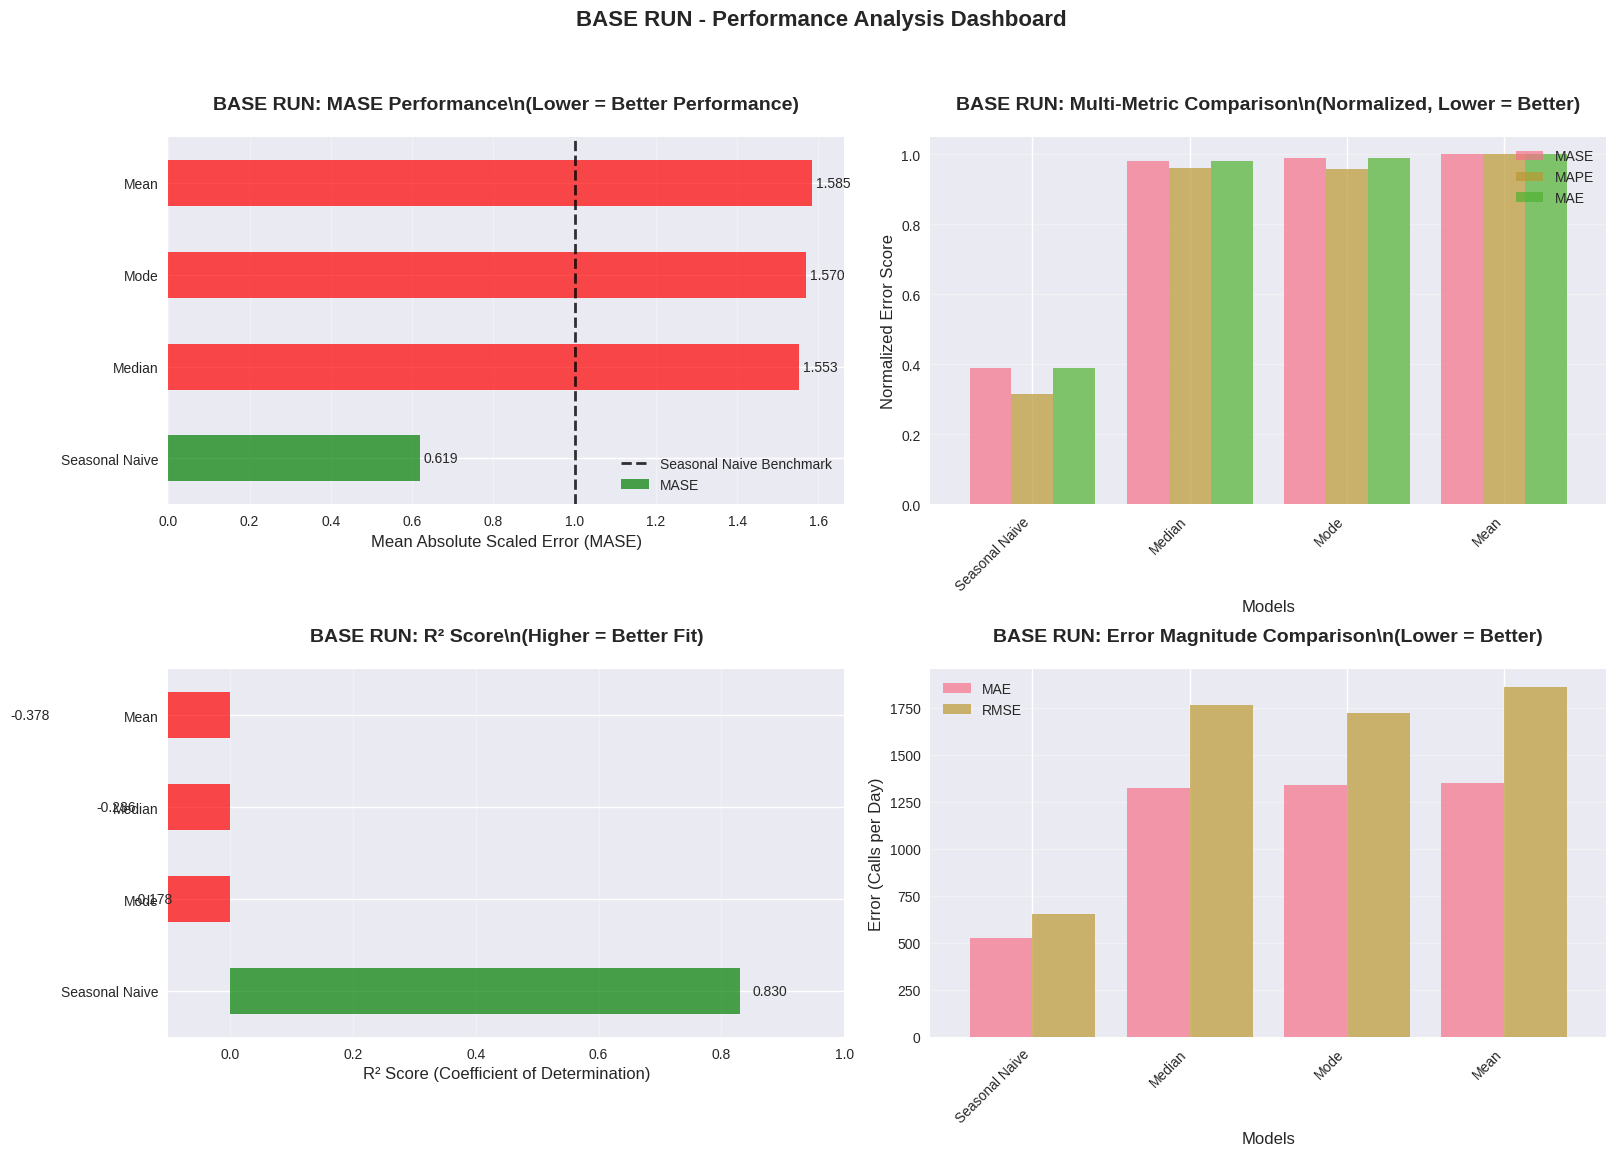

\nVISUALIZATION SUMMARY:
--------------------------------------------------
Best Performing Model: Seasonal Naive
Best MASE Score: 0.6186
Models Beating Benchmark: 1/4
Average MASE: 1.3316
Performance Spread: 0.619 - 1.585
Status: Success - 1 model(s) beat seasonal naive
--------------------------------------------------
\nStep 6: Saving results to files...
   Detailed results saved: base_run_detailed_results.csv
   Summary report saved: base_run_summary_report.csv
\n================================================================================
BASE RUN EVALUATION COMPLETED SUCCESSFULLY!
Execution Time: 0.86 seconds
Models Evaluated: 4
Champion Model: Seasonal Naive
Champion MASE: 0.6186
Success Rate: 1/4 models beat seasonal naive
Files Generated: base_run_detailed_results.csv, base_run_summary_report.csv
\nNEXT STEPS:
1. Review the performance report above
2. Examine the visualization dashboard
3. Check saved CSV files for detailed metrics
4. Use best performing model as baseline f

In [11]:
# FINAL EXECUTION - BASE RUN EVALUATION
print("INITIATING BASE RUN EVALUATION")
print("=" * 60)
print("Loading data and executing basic benchmark evaluation...")

# Start timing
execution_start_time = time.time()

try:
    # Step 1: Load data
    print("\\nStep 1: Loading call center data...")
    df_raw = load_call_center_data_base_run()

    if df_raw is None:
        raise Exception("Data loading failed - check file path and format")

    # Step 2: Create cross-validation splits
    print("\\nStep 2: Creating time series cross-validation splits...")
    cv_splits = create_time_series_splits_base_run(df_raw, n_splits=1, test_size=7)

    if not cv_splits:
        raise Exception("Cross-validation split creation failed")

    # Step 3: Run base run evaluation
    print("\\nStep 3: Running base run evaluation...")
    print("This will evaluate only the 4 core baseline models...")

    results_df, avg_results = run_base_run_evaluation()

    if results_df is None or avg_results is None:
        raise Exception("Base run evaluation failed")

    # Step 4: Generate standardized report
    print("\\nStep 4: Generating performance report...")
    final_report = create_base_run_report(results_df, avg_results, "BASE RUN - BASIC BENCHMARKS")

    # Step 5: Create visualizations
    print("\\nStep 5: Creating performance visualizations...")
    visualization_fig = create_base_run_visualizations(results_df, avg_results, "BASE RUN")

    # Step 6: Save results
    print("\\nStep 6: Saving results to files...")

    # Save detailed results
    results_filename = 'base_run_detailed_results.csv'
    results_df.to_csv(results_filename, index=False)
    print(f"   Detailed results saved: {results_filename}")

    # Save summary report
    summary_filename = 'base_run_summary_report.csv'
    final_report.to_csv(summary_filename)
    print(f"   Summary report saved: {summary_filename}")

    # Calculate execution time
    execution_time = time.time() - execution_start_time

    # Final summary
    print("\\n" + "=" * 80)
    print("BASE RUN EVALUATION COMPLETED SUCCESSFULLY!")
    print("=" * 80)

    best_model_name = avg_results.index[0].replace(f'_{MODEL_VERSION}', '').replace('_', ' ').title()
    best_mase = avg_results.iloc[0]['MASE']
    models_beating_benchmark = (avg_results['MASE'] < 1.0).sum()
    total_models = len(avg_results)

    print(f"Execution Time: {execution_time:.2f} seconds")
    print(f"Models Evaluated: {total_models}")
    print(f"Champion Model: {best_model_name}")
    print(f"Champion MASE: {best_mase:.4f}")
    print(f"Success Rate: {models_beating_benchmark}/{total_models} models beat seasonal naive")
    print(f"Files Generated: {results_filename}, {summary_filename}")

    print("\\nNEXT STEPS:")
    print("1. Review the performance report above")
    print("2. Examine the visualization dashboard")
    print("3. Check saved CSV files for detailed metrics")
    print("4. Use best performing model as baseline for complex models")
    print("5. Consider seasonal patterns if no models beat benchmark")

    print("\\nBASE RUN CHARACTERISTICS:")
    print("• No hyperparameter optimization")
    print("• No complex feature engineering")
    print("• Single cross-validation split")
    print("• Default model parameters only")
    print("• Focus on interpretability over complexity")

    print("=" * 80)

except Exception as e:
    execution_time = time.time() - execution_start_time
    print(f"\\n*** BASE RUN EXECUTION FAILED ***")
    print(f"Error: {str(e)}")
    print(f"Execution time before failure: {execution_time:.2f} seconds")
    print("\\nTroubleshooting:")
    print("1. Check if data file exists and is accessible")
    print("2. Verify data format matches expected structure")
    print("3. Ensure all required libraries are installed")
    print("4. Review error message above for specific issues")
    print("\\nContact support or check documentation for assistance")

    # Still try to show what we have
    if 'df_raw' in locals() and df_raw is not None:
        print(f"\\nData was loaded successfully: {len(df_raw)} records")
    if 'cv_splits' in locals() and cv_splits:
        print(f"CV splits were created: {len(cv_splits)} splits")

print("\\nBase run execution completed.")

What This Tells You About Your Business
Call Patterns: Your call center has very predictable weekly cycles. Mondays behave like Mondays, Tuesdays like Tuesdays, etc. Simple averages fail because they ignore these patterns.
Forecasting Needs: Any useful forecasting system must account for day-of-week effects. Methods that ignore seasonality will consistently underperform.
Resource Planning: Your staffing should be based on weekly patterns, not overall averages. A Tuesday average is meaningless - you need "Tuesday patterns."
Base Run Value
Even though the basic models will underperform, the base run still provides value by:

Confirming seasonal patterns dominate your data
Establishing that simple approaches are insufficient
Quantifying exactly how much weekly patterns matter (seasonal naive beats mean by ~2.2x)
Providing clear justification for investing in seasonal-aware forecasting

Your base run will essentially prove that "one-size-fits-all" daily averages don't work for your operation - you need day-specific approaches.